In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,precision_recall_curve, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV



In [3]:
pd.options.display.max_columns

20

### Abrimos nuestro dataset ya limpio

In [5]:
df= pd.read_csv('../data/processed/df_encoded.csv')
df.shape

(12000, 26)

In [6]:
df

genero_etiqueta      Time  Time_mean  Location_encoded  Zone_encoded  \
0             Homininos  6.041124        NaN                 0             1   
1             Homininos  4.383910   4.191768                 0             1   
2      Australopithecus  3.749413   4.081872                 0             1   
3      Australopithecus  4.595606        NaN                 0             1   
4      Australopithecus  3.614060   3.691841                 0             2   
...                 ...       ...        ...               ...           ...   
11995  Australopithecus  3.354085   3.691841                 0             2   
11996  Australopithecus  3.969730   3.691841                 0             2   
11997             Otros  0.213857   0.498162                 1             1   
11998      Paranthropus  2.859186   2.774076                 0             1   
11999      Paranthropus  2.237098   2.100025                 0             2   

       Habitat_encoded  Incisor_Size_encoded  Jaw_Shape_encoded  \
0             0.083333                     2                  4   
1             0.250000                     2                  4   
2             0.250000                     4                  3   
3             0.083333                     4                  3   
4             0.083333                     2                  4   
...                ...                   ...                ...   
11995         0.083333                     2                  4   
11996         0.083333                     2                  4   
11997         0.041667                     2                  3   
11998         0.041667                     5                  1   
11999         0.083333                     5                  1   

       Torus_Supraorbital_encoded  Prognathism_encoded  ...  Biped_encoded  \
0                               1                    1  ...              0   
1                               1                    1  ...              1   
2                               1                    1  ...              2   
3                               1                    1  ...              2   
4                               1                    2  ...              2   
...                           ...                  ...  ...            ...   
11995                           1                    2  ...              2   
11996                           1                    2  ...              2   
11997                           3                    2  ...              3   
11998                           0                    0  ...              2   
11999                           0                    0  ...              2   

       foots_encoded  Diet_encoded  Sexual_Dimorphism_encoded  Hip_encoded  \
0                  0             4                          0            1   
1                  0             2                          1            1   
2                  1             4                          0            0   
3                  0             4                          0            1   
4                  0             4                          0            1   
...              ...           ...                        ...          ...   
11995              0             4                          0            1   
11996              0             4                          0            1   
11997              1             1                          1            1   
11998              0             3                          0            1   
11999              0             3                          0            1   

       Vertical_Front_encoded  Anatomy_encoded  Migrated_encoded  \
0                           0                0                 0   
1                           0                0                 0   
2                           0                0                 0   
3                           0                1                 0   
4                           

In [7]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(numeric_only=True),annot=True,cmap='coolwarm')

<Axes: >

### Aqui voy a dividir y dataframe limpio en train y test y los guardo como csv para ya poder empezar a entrenar modelos, usando solo train y hacer las pruebas con mi test

In [9]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

print(train_df.shape)
print(test_df.shape)

train_df.to_csv('../data/train/train.csv', index=False)
test_df.to_csv('../data/test/test.csv', index=False)

(9600, 26)
(2400, 26)


In [49]:
df_train= pd.read_csv('../data/train/train.csv')

In [50]:
plt.figure(figsize=(20,20))
sns.heatmap(df_train.corr(numeric_only=True),annot=True,cmap='coolwarm')

<Axes: >

In [51]:
df_train.columns

Index(['genero_etiqueta', 'Time', 'Time_mean', 'Location_encoded',
       'Zone_encoded', 'Habitat_encoded', 'Incisor_Size_encoded',
       'Jaw_Shape_encoded', 'Torus_Supraorbital_encoded',
       'Prognathism_encoded', 'Foramen_encoded', 'Canine_Size_encoded',
       'Canines_Shape_encoded', 'Tooth_Enamel_encoded', 'Tecno_encoded',
       'tecno_type_mapping_encoded', 'Biped_encoded', 'foots_encoded',
       'Diet_encoded', 'Sexual_Dimorphism_encoded', 'Hip_encoded',
       'Vertical_Front_encoded', 'Anatomy_encoded', 'Migrated_encoded',
       'genero_etiqueta_num'],
      dtype='object')

In [52]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9600 entries, 0 to 9599
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   genero_etiqueta             9600 non-null   object 
 1   Time                        9600 non-null   float64
 2   Time_mean                   8410 non-null   float64
 3   Location_encoded            9600 non-null   int64  
 4   Zone_encoded                9600 non-null   int64  
 5   Habitat_encoded             9600 non-null   float64
 6   Incisor_Size_encoded        9600 non-null   int64  
 7   Jaw_Shape_encoded           9600 non-null   int64  
 8   Torus_Supraorbital_encoded  9600 non-null   int64  
 9   Prognathism_encoded         9600 non-null   int64  
 10  Foramen_encoded             9600 non-null   int64  
 11  Canine_Size_encoded         9600 non-null   int64  
 12  Canines_Shape_encoded       9600 non-null   int64  
 13  Tooth_Enamel_encoded        9600 

### Divido en X,y sobre el train cogiendo las variables que creo que más correlacionan con el target y que menos multicolinealidad tienen

In [53]:
X=df_train[['Time','Biped_encoded','Foramen_encoded','Torus_Supraorbital_encoded','Tecno_encoded','Diet_encoded']]
y= df_train['genero_etiqueta_num']
print(X.shape)
print(y.shape)

(9600, 6)
(9600,)


In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(7680, 6)
(7680,)
(1920, 6)
(1920,)


### Primer modelo de prueba para ver qué tal he hecho el feature engineering

In [56]:
rnd_clf = RandomForestClassifier(n_estimators=500,
                                 max_depth=5,
                                 max_leaf_nodes=16,
                                 random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

scores = cross_val_score(rnd_clf, X, y, cv=5) 
precision = precision_score(y_test, y_pred_rf, average='macro')
recall = recall_score(y_test, y_pred_rf, average='macro')
f1 = f1_score(y_test, y_pred_rf, average='macro')
accuracy = accuracy_score(y_test, y_pred_rf)
mean_score = scores.mean()

print("Cross-validation scores:", scores)
print("Mean cross-validation score:", mean_score)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Cross-validation scores: [0.95572917 0.94791667 0.93385417 0.9359375  0.94583333]
Mean cross-validation score: 0.9438541666666665
Accuracy: 0.9463541666666667
Precision: 0.9390408121917475
Recall: 0.9570529599487463
F1-score: 0.9465190745792906


In [57]:
df_test= pd.read_csv('../data/test/test.csv')


In [58]:
X1=df_test[['Time','Biped_encoded','Foramen_encoded','Torus_Supraorbital_encoded','Tecno_encoded','Diet_encoded']]
y1= df_test['genero_etiqueta_num']

In [69]:
y_pred_rf_test = rnd_clf.predict(X1)
y_pred_rf_test_pproba = rnd_clf.predict_proba(X1)

In [60]:
y_pred_rf_test

array([1, 1, 1, ..., 0, 1, 0], dtype=int64)

In [70]:
y_pred_rf_test_pproba

array([[1.43633880e-03, 9.91651164e-01, 6.24570025e-04, 6.28792711e-03,
        0.00000000e+00, 0.00000000e+00],
       [3.90565140e-03, 9.91465786e-01, 0.00000000e+00, 4.62856263e-03,
        0.00000000e+00, 0.00000000e+00],
       [1.43633880e-03, 9.93935099e-01, 0.00000000e+00, 4.62856263e-03,
        0.00000000e+00, 0.00000000e+00],
       ...,
       [9.68140178e-01, 2.88178016e-02, 1.49132948e-03, 1.55069066e-03,
        0.00000000e+00, 0.00000000e+00],
       [4.15149716e-03, 9.91219940e-01, 0.00000000e+00, 4.62856263e-03,
        0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]])

In [71]:
precision = precision_score(y1, y_pred_rf_test, average='macro')
recall = recall_score(y1, y_pred_rf_test, average='macro')
f1 = f1_score(y1, y_pred_rf_test, average='macro')
roc_auc= roc_auc_score(y1,y_pred_rf_test_pproba,average='weighted',multi_class='ovo')


print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print('ROC AUC score:', roc_auc)


Precision: 0.9369852538545547
Recall: 0.9634485763135398
F1-score: 0.948116128266134
ROC AUC score: 0.9972361175043657


### Modelo de random forest con pca 5 componentes , aunque mi x tiene solo 6, luego pruebo con todas las columnas

In [73]:



steps = [
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('classifier', RandomForestClassifier(random_state=42))
]

pipeline = Pipeline(steps)

param_dist = {
    'pca__n_components': [2, 5, 10],
    'classifier__n_estimators': [100, 500, 1000],
    'classifier__max_depth': [3, 5, 10],
    'classifier__max_leaf_nodes': [10, 16, 20]
}

random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, cv=5, n_iter=10, random_state=42,verbose= 2)


rs=random_search.fit(X_train, y_train)

best_score = random_search.best_score_
best_params = random_search.best_params_

print("Best Score:", best_score)
print("Best Parameters:", best_params)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END classifier__max_depth=5, classifier__max_leaf_nodes=10, classifier__n_estimators=500, pca__n_components=2; total time=   1.4s
[CV] END classifier__max_depth=5, classifier__max_leaf_nodes=10, classifier__n_estimators=500, pca__n_components=2; total time=   1.3s
[CV] END classifier__max_depth=5, classifier__max_leaf_nodes=10, classifier__n_estimators=500, pca__n_components=2; total time=   1.3s
[CV] END classifier__max_depth=5, classifier__max_leaf_nodes=10, classifier__n_estimators=500, pca__n_components=2; total time=   1.3s
[CV] END classifier__max_depth=5, classifier__max_leaf_nodes=10, classifier__n_estimators=500, pca__n_components=2; total time=   1.3s
[CV] END classifier__max_depth=3, classifier__max_leaf_nodes=10, classifier__n_estimators=100, pca__n_components=2; total time=   0.1s
[CV] END classifier__max_depth=3, classifier__max_leaf_nodes=10, classifier__n_estimators=100, pca__n_components=2; total time=  

In [74]:
best_estimator = random_search.best_estimator_
print('best estimator',best_estimator)

best estimator Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=5)),
                ('classifier',
                 RandomForestClassifier(max_depth=5, max_leaf_nodes=10,
                                        random_state=42))])


In [75]:
be=rs.best_estimator_.fit(X_train,y_train)


#### METRICAS SOBRE TEST

In [76]:
y_pred_rf_pca_test1=be.predict(X1)
y_pred_rf_pca_test1_pproba = be.predict_proba(X1)

In [78]:
precision1 = precision_score(y1, y_pred_rf_pca_test1,average='weighted')
recall1 = recall_score(y1, y_pred_rf_pca_test1,average='weighted')
f11 = f1_score(y1, y_pred_rf_pca_test1,average='weighted')

roc_auc1= roc_auc_score(y1,y_pred_rf_pca_test1_pproba,average='weighted',multi_class='ovo')
print("Precision:", precision1)
print("Recall:", recall1)
print("F1-score:", f11)
print('ROC AUC score:', roc_auc1)

Precision: 0.9552281319493479
Recall: 0.9541666666666667
F1-score: 0.95422984634526
ROC AUC score: 0.9973566927497032


[[298   0   0   0   0   0]
 [  0 613   0   0   0   0]
 [  0   0 337   0   0   0]
 [  0   0   0 637  46   2]
 [  0   0   0  35 261   0]
 [  0   0   0  27   0 144]]


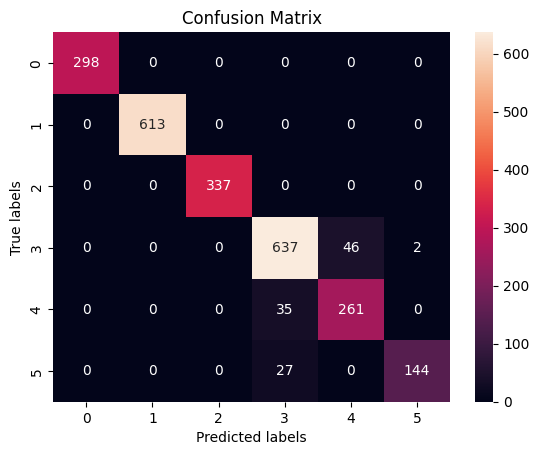

In [85]:
c_matrix = confusion_matrix(y1,y_pred_rf_pca_test1)
print(c_matrix)
import seaborn as sns
sns.heatmap(c_matrix, annot=True,fmt= 'd')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show();

#### METRICAS SOBRE TRAIN:

In [79]:
y_pred_rf_pca_train1=be.predict(X)
y_pred_rf_pca_train1_pproba = be.predict_proba(X)

In [81]:
precision_train = precision_score(y, y_pred_rf_pca_train1,average='weighted')
recall_train = recall_score(y, y_pred_rf_pca_train1,average='weighted')
f1_train = f1_score(y, y_pred_rf_pca_train1,average='weighted')

roc_auc_train= roc_auc_score(y,y_pred_rf_pca_train1_pproba,average='weighted',multi_class='ovo')

In [82]:
print("Precision:", precision_train)
print("Recall:", recall_train)
print("F1-score:", f1_train)
print('ROC AUC score:', roc_auc_train)

Precision: 0.9581458253329398
Recall: 0.9571875
F1-score: 0.9572352786156519
ROC AUC score: 0.9976066201411958


#### LAS PRIMERAS METRICAS QUE SAQUE

In [64]:
y_pred_rf_pca_test = best_estimator.predict(X1)
y_pred_rf_pca_test_pproba = best_estimator.predict_proba(X1)
y_pred_rf_pca_test

array([1, 1, 1, ..., 0, 1, 0], dtype=int64)

In [68]:
precision = precision_score(y1, y_pred_rf_pca_test,average='weighted')
recall = recall_score(y1, y_pred_rf_pca_test,average='weighted')
f1 = f1_score(y1, y_pred_rf_pca_test,average='weighted')

roc_auc= roc_auc_score(y1,y_pred_rf_pca_test_pproba,average='weighted',multi_class='ovo')

precision_train = precision_score(y1, y_pred_rf_pca_test,average='weighted')
recall_train = recall_score(y1, y_pred_rf_pca_test,average='weighted')
f1_train = f1_score(y1, y_pred_rf_pca_test,average='weighted')

roc_auc_train= roc_auc_score(y1,y_pred_rf_pca_test_pproba,average='weighted',multi_class='ovo')


print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print('ROC AUC score:', roc_auc)

Precision: 0.9552281319493479
Recall: 0.9541666666666667
F1-score: 0.95422984634526
ROC AUC score: 0.9973566927497032


In [ ]:
y1

0       1
1       1
2       1
3       1
4       1
       ..
2395    5
2396    1
2397    0
2398    1
2399    0
Name: genero_etiqueta_num, Length: 2400, dtype: int64

In [ ]:
t1=pd.concat([pd.DataFrame(y_pred_rf_pca_test),y1],axis=1)


In [ ]:
t1

0  genero_etiqueta_num
0     1                    1
1     1                    1
2     1                    1
3     1                    1
4     1                    1
...  ..                  ...
2395  5                    5
2396  1                    1
2397  0                    0
2398  1                    1
2399  0                    0

[2400 rows x 2 columns]